**Attacking MNIST Dataset**

Here we use a custom NN trained on MNIST data to perform *zero order Stochastic Gradient Descent*

**Set current directory**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/My Drive/Colab Notebooks/Adversarial/AdvAttack/src

In [1]:
cd src

C:\Users\fgrim\Desktop\AdvAttack\src


In [2]:
import loss as customLoss
import zeroOptim 
import mnist

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from torchvision import transforms
import torch
from torch import nn, optim

**Retrieve MNIST data**

We retrieve the MNIST data. <br>
The default *trasnform.compose* method resize the data from (28, 28, 1) to (299, 299, 3) so that it is ready for *InceptionV3*. Here we use the base *transforme.compose*

In [3]:
base_transform = transforms.Compose([transforms.ToTensor()])


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


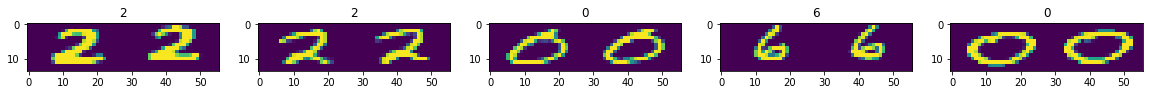

In [4]:
DataLoader = mnist.MNIST(transform=base_transform)
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**Build a custom Neural Network**

The network has as feature extractor 6 CNN layer with Dropout and as Classifier 3 Linear layer.

In [5]:
class Net(nn.Module):

        def __init__(self):
            super().__init__()
            
            self.FeatureExtractor = nn.Sequential(nn.Conv2d(1, 8, (2, 2), stride=1, padding=1), nn.ReLU(),
                                                  nn.Conv2d(8, 16, (2, 2), stride=1, padding=1), nn.ReLU(),
                                                  nn.MaxPool2d(kernel_size=(2, 2)),
                                                  nn.Conv2d(16, 20, (2, 2), stride=1, padding=1), nn.ReLU(),
                                                  nn.Conv2d(20, 24, (2, 2), stride=1, padding=1), nn.ReLU(),
                                                  nn.MaxPool2d(kernel_size=(2, 2)))
            
            self.Classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(24*8*8, 256), nn.Dropout(0.3), nn.ReLU(),
                                            nn.Linear(256, 64), nn.Dropout(0.3), nn.ReLU(),                                          
                                            nn.Linear(64, 10))


        def forward(self, x):
            cnn_x = self.FeatureExtractor(x) 
            out = self.Classifier(cnn_x)
            return out

In [6]:
def train_step(trainloader, loss_fn, optimizer):
         ### 1. Train
        net.train()
        ### 1.1 Define vars
        loss, accuracy = [], []

        for batch in tqdm(trainloader):
            optimizer.zero_grad()
            ### 1.2 Feed the network
            X, y = batch[0].to(device), batch[1].to(device)
            out = net(X)
            ### 1.3 Compute loss and back-propagate
            crn_loss = loss_fn(out, y)
            crn_loss.backward()
            optimizer.step()
            ### 1.4 Save results
            loss.append(crn_loss.data.item())
            accuracy.append(accuracy_score(batch[1].numpy(), np.argmax(out.cpu().detach().numpy(), axis=1)))

        return np.mean(loss), np.mean(accuracy)

def eval_step(testloader, loss_fn):
    ### 1. Eval
    net.eval()
    ### 1.1 Define vars
    loss, accuracy = [], []

    with torch.no_grad():
        for batch in tqdm(testloader):
            ### 1.2 Feed the network
            X, y = batch[0].to(device), batch[1].to(device)
            out = net(X)
            ### 1.3 Compute loss
            crn_loss = loss_fn(out, y)
            ### 1.4 Save results
            loss.append(crn_loss.data.item())
            accuracy.append(accuracy_score(batch[1], np.argmax(out.cpu().detach().numpy(), axis=1)))

    return np.mean(loss), np.mean(accuracy)

In [7]:
device = torch.device('cuda')
net = Net().to(device)

In [8]:
import time
try:
    net = torch.load('../models/mnistBaseV2.pth')
except:
    optimizer = optim.Adam(net.parameters(), lr = 0.0001)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(5):
        loss, acc = train_step(train, loss_fn, optimizer)
        time.sleep(0.2)
        loss_val, acc_val = eval_step(test, loss_fn)
        time.sleep(0.2)
        print('Epoch: {}'.format(ep+1), end='\t')
        print('Train loss:{:.4f}\t Train Accuracy:{:.3f}'.format(loss, acc), end='\t')
        print('Valid loss:{:.4f}\t Valid Accuracy:{:.3f}'.format(loss_val, acc_val))
        time.sleep(0.2)
    try:
        torch.save(net, '../models/mnistBaseV2.pth')
    except:
        pass

**Attack the network**

Here we try to start with a random rightfully classified image from the validation set and we try to use *zero order Stochastic Gradient Descent* to modify the image in order to make the network be mistaken.

We can set an epsilon as an upper bound for the inifinity norm of our input.

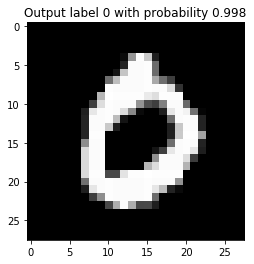

In [9]:
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img = X[3].cpu().numpy()
out = nn.Softmax(dim=1)(net(X[3].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out[0, original_label])))
plt.show()

  1%|▋                                                                                | 8/1000 [00:00<01:17, 12.73it/s]


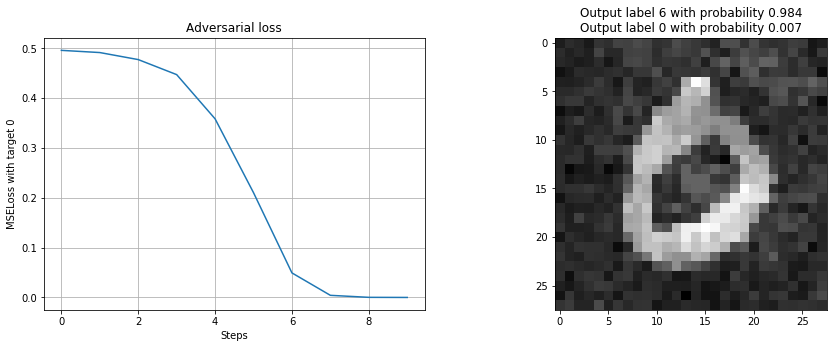

In [10]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.SpecificSoftmaxMSE(neuron=0, y_true=0)
adv_optimizer = zeroOptim.ZeroSGD(net, adv_loss, 'cuda')
### Run the optimizer
EPOCH = 1000
x, loss, outs = adv_optimizer.run(X[3], 
                                  v=0.2, 
                                  mk=[600]*EPOCH, 
                                  ak=[0.8]*EPOCH,
                                  stop_criterion = 1e-4, 
                                  epsilon=0.35, 
                                  max_steps=EPOCH, 
                                  verbose=0, 
                                  additional_out = False)

out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('Output label {} with probability {:.3f}\nOutput label {} with probability {:.3f}'.format(label, float(out[0, label]), original_label, float(out[0, original_label])))
plt.show()

**Random start**

If before we started with a validation example, now we can try to create our random input and transform it in order to be classified as a desired number (e.g. 1).

We just change the loss having as target neuron 1 and as target output 1 (maximum probability). 

 40%|███████████████████████████████▉                                                 | 79/200 [00:03<00:06, 19.78it/s]


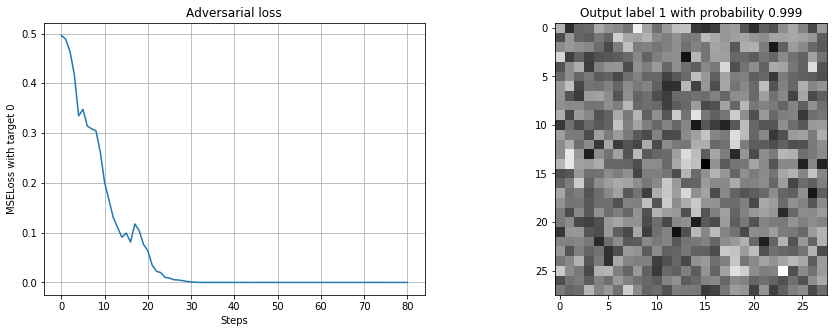

In [11]:
x = torch.randn(1, 28, 28)
### 
adv_loss = customLoss.SpecificSoftmaxMSE(neuron=1, y_true=1)
adv_optimizer = zeroOptim.ZeroSGD(net, adv_loss, 'cuda')
### Run the optimizer
### Run the optimizer
EPOCH = 200
x, loss, outs = adv_optimizer.run(x, 
                                  v=1, 
                                  mk=[600]*EPOCH, 
                                  ak=[4]*EPOCH,
                                  stop_criterion = 1e-6, 
                                  epsilon= 0.6, 
                                  max_steps=EPOCH, 
                                  verbose=0)

out = nn.Softmax(dim=1)(net(x.reshape(1, 1, 28, 28)))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('Output label {} with probability {:.3f}'.format(label, float(out[0, label])))
plt.show()

**Success rate at different infinity norm upper bound**

Here we can see how the algorithm perform when it goes from stricter to less strict epsilon with the first 10 validation images.

**BETTER ON COLAB**

In [23]:
device = torch.device('cuda')
EPOCH = 100
def evaluate(e, n=7, mk=28**2, ak=0.8, v=0.2):
    X_test = X[:n, ...]
    success = []
    xs = []
    for x in tqdm(X_test):
        y_before = int(torch.argmax(net(x.to(device).view(1, 1, 28, 28))))
        loss = customLoss.SpecificSoftmaxMSE(neuron=y_before, y_true=0, dim=1)
        ADVoptim = zeroOptim.ZeroSGD(model=net, loss=loss, device=device)
        x_out, loss_curve, out =  ADVoptim.run(x, 
                                               v=v, 
                                               mk=[mk]*EPOCH, 
                                               ak=[ak]*EPOCH,
                                               stop_criterion = 1e-2, 
                                               epsilon=e, 
                                               max_steps=EPOCH, 
                                               verbose=0,
                                               tqdm_disable=True)

        if int(torch.argmax(net(x_out)).item()) != y_before:
            success.append(1)
        else:
            success.append(0)
        xs.append(x_out)
    return success, xs

net = net.to(device)
epsilon = 0.20
success_list, out_list = evaluate(epsilon)
print('Success rate with epsilon = {}:\t{:.1f}%'.format(epsilon, 100*np.sum(success_list)/len(success_list)))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]

Success rate with epsilon = 0.2:	85.7%


In [ ]:
fig, ax = plt.subplots(9, 7, figsize = (30, 31))
for n in range(7):
    out_before = int(torch.argmax(net(X[n, ...].to(device).view(1, 1, 28, 28))))
    img_before = X[n, ...].detach().cpu().numpy()
    ax[0, n].imshow(img_before.reshape(28, 28), cmap='gray')
    ax[0, n].set_title(out_before)
for i in range(1, 9):
    a1, b1 = evaluate(0.1*i)
    for n, t in enumerate(zip(a1, b1)):
        out_after = int(torch.argmax(net(t[1])))
        img_after = t[1].detach().cpu().numpy()
        ax[i, n].imshow(img_after.reshape(28, 28), cmap='gray')
        ax[i, n].set_title('{}, eps = {:.2f}'.format(out_after, float(i*0.1)))
plt.show()